In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle
import random
import re

In [2]:
# Suppress TensorFlow logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [3]:
# Custom Attention Layer
@tf.keras.utils.register_keras_serializable()
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        context = inputs * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

In [4]:
# Configuration
vocab_size = 20000
max_length = 30
embedding_dim = 128
oov_token = '<OOV>'
batch_size = 512

In [5]:
# Emoji preprocessing
emoji_dict = {
    r'[:\)\(]+': 'emoji_positive',
    r'[:\+\-\|\/]+': 'emoji_neutral',
    r'[:\(]+': 'emoji_negative',
    r'[😊👍🌟😎🔥💯😍😀😄😜]': 'emoji_positive',
    r'[😢😣😠😤😒]': 'emoji_negative',
    r'[😏🤔🤷]': 'emoji_neutral'
}

# Slang normalization
slang_dict = {
    'wtf': 'what the fuck',
    'lol': 'laughing out loud',
    'fr': 'for real',
    'tbh': 'to be honest',
    'fucking': 'fuckin',
    'fuckinng': 'fuckin',
    'ur': 'your',
    'r': 'are'
}

def preprocess_emojis(text):
    for pattern, replacement in emoji_dict.items():
        text = re.sub(pattern, f' {replacement} ', text)
    return text

def normalize_slang(text):
    for slang, full in slang_dict.items():
        text = re.sub(r'\b' + slang + r'\b', full, text)
    return text

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s!?😊👍🌟😎🔥💯😍😢😣😠😤😒😏🤔🤷😀😄😜]', '', text)  # Keep letters, spaces, punctuation, emojis
    text = re.sub(r'\s+', ' ', text).strip()
    text = normalize_slang(text)
    text = preprocess_emojis(text)
    return text

# Data augmentation with synonym replacement
def augment_text(text, class_type='hate'):
    if class_type == 'hate':
        synonyms = {
            'scam': ['fraud', 'swindle'],
            'ripoff': ['cheat', 'fraud'],
            'garbage': ['junk', 'trash'],
            'worst': ['terrible', 'awful'],
            'crooks': ['thieves', 'criminals'],
            'disgusting': ['gross', 'revolting'],
            'lazy': ['idle'],
            'leeches': ['parasites'],
            'ban': ['prohibit'],
            'ruining': ['wrecking'],
            'terrorists': ['extremists']
        }
    elif class_type == 'offensive':
        synonyms = {
            'asshole': ['jerk', 'idiot'],
            'bitch': ['jerk'],
            'dumbass': ['idiot', 'fool'],
            'loser': ['nobody'],
            'moron': ['idiot'],
            'shit': ['crap'],
            'fuck': ['screw']
        }
    else:  # neither
        synonyms = {
            'great': ['awesome', 'wonderful'],
            'nice': ['pleasant', 'lovely'],
            'good': ['excellent', 'fine'],
            'beautiful': ['lovely'],
            'cool': ['neat'],
            'bro': ['mate', 'dude'],
            'okay': ['alright'],
            'bad': ['poor'],
            'well': ['nicely'],
            'done': ['finished'],
            'dope': ['lit']
        }
    words = text.split()
    for i, word in enumerate(words):
        if word in synonyms and random.random() < 0.3:
            words[i] = random.choice(synonyms[word])
    return ' '.join(words)

def random_augment(text, class_type):
    text = augment_text(text, class_type)
    words = text.split()
    if len(words) > 2 and random.random() < 0.1:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
    return ' '.join(words)

def add_misspelling(text, class_type):
    misspellings = {
        'fucking': ['fuckin'],
        'moron': ['moran'],
        'asshole': ['asshol'],
        'nigger': ['nigga']
    }
    for word, variants in misspellings.items():
        if word in text and random.random() < 0.2:
            text = text.replace(word, random.choice(variants))
    return text

In [6]:
# Load and preprocess data
df = pd.read_csv("labeled_data_clean.csv")
df = df.rename(columns={"clean_tweet": "text", "class": "label"})
df["label"] = df["label"].astype(int)
df = df.dropna(subset=['text'])
df['text'] = df['text'].apply(clean_text)
df = df[df['text'].str.len() > 0]

In [7]:
# Oversampling
df_hate = df[df.label == 0]
df_offensive = df[df.label == 1]
df_neither = df[df.label == 2]

df_hate_upsampled = resample(df_hate, replace=True, n_samples=15000, random_state=42)
df_offensive_upsampled = resample(df_offensive, replace=True, n_samples=15000, random_state=42)
df_neither_upsampled = resample(df_neither, replace=True, n_samples=15000, random_state=42)
df_balanced = pd.concat([df_offensive_upsampled, df_hate_upsampled, df_neither_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)

In [8]:
# Add synthetic data (9,000 total)
hate_synthetic = [
    ("migrants are wrecking our land", 0),
    ("this business is a fraud", 0),
    ("extremists should be prohibited", 0),
    ("foreigners are junk", 0),
    ("this group is gross", 0),
    ("parasites steal our jobs", 0),
    ("muslims are terrorists ban them all", 0),
    ("black people are just lazy leeches", 0),
    ("these immigrants are ruining our country", 0),
    ("gays shouldnt be allowed in public", 0)
] * 300  # 3,000 samples
offensive_synthetic = [
    ("youre a total jerk", 1),
    ("screw you idiot", 1),
    ("your ideas are crap", 1),
    ("get lost fool", 1),
    ("youre a nobody", 1),
    ("what a bitch always complaining", 1),
    ("your opinion is pure garbage", 1),
    ("this app is a ripoff pure garbage", 1),
    ("you are useless asshole", 1),
    ("this shit is disgusting", 1)
] * 300  # 3,000 samples
neither_synthetic = [
    ("beautiful day today emoji_positive", 2),
    ("amazing movie tonight emoji_positive", 2),
    ("great job friend emoji_positive", 2),
    ("okay service emoji_neutral", 2),
    ("nice vibe emoji_positive", 2),
    ("hello guys im here emoji_neutral", 2),
    ("omg beautiful emoji_positive", 2),
    ("holy this is cool emoji_positive", 2),
    ("fantastic stream emoji_positive", 2),
    ("good stuff mate emoji_positive", 2),
    ("lets go emoji_positive", 2),
    ("are you serious emoji_neutral", 2),
    ("wtf just happened emoji_neutral", 2),
    ("great bro emoji_positive", 2),
    ("not bad emoji_neutral", 2),
    ("well done emoji_positive", 2),
    ("had a long day need a nap emoji_neutral", 2),
    ("cool stuff emoji_positive", 2),
    ("lets fuckin go emoji_positive", 2),
    ("this is fuckin awesome emoji_positive", 2),
    ("yo this game is dope emoji_positive", 2),
    ("beautiful weather for a walk today emoji_positive", 2),
    ("i love you emoji_positive", 2),
    ("i mean thats alright emoji_neutral", 2),
    ("just stop doing that emoji_neutral", 2)
] * 120  # 3,000 samples

hate_synthetic_df = pd.DataFrame(hate_synthetic, columns=['text', 'label'])
hate_synthetic_df['text'] = hate_synthetic_df['text'].apply(lambda x: add_misspelling(random_augment(x, class_type='hate'), class_type='hate'))
offensive_synthetic_df = pd.DataFrame(offensive_synthetic, columns=['text', 'label'])
offensive_synthetic_df['text'] = offensive_synthetic_df['text'].apply(lambda x: add_misspelling(random_augment(x, class_type='offensive'), class_type='offensive'))
neither_synthetic_df = pd.DataFrame(neither_synthetic, columns=['text', 'label'])
neither_synthetic_df['text'] = neither_synthetic_df['text'].apply(lambda x: add_misspelling(random_augment(x, class_type='neither'), class_type='neither'))
df_balanced = pd.concat([df_balanced, hate_synthetic_df, offensive_synthetic_df, neither_synthetic_df])
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Precompute augmentation
texts = df_balanced['text'].astype(str).values
labels = df_balanced['label'].values
augmented_texts = []
augmented_labels = []

for text, label in zip(texts, labels):
    class_type = {0: 'hate', 1: 'offensive', 2: 'neither'}[label]
    augmented_texts.append(add_misspelling(random_augment(text, class_type), class_type))
    augmented_labels.append(label)

In [9]:
# Tokenize and pad
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_balanced['text'].values)  # Fit on non-augmented texts
sequences = tokenizer.texts_to_sequences(augmented_texts)
padded_sequences = np.clip(pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post'), 0, vocab_size - 1)
augmented_labels = np.array(augmented_labels)


In [10]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, augmented_labels, test_size=0.3, random_state=42, stratify=augmented_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [11]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
# Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.4, kernel_regularizer=l2(1e-3))),
    Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, kernel_regularizer=l2(1e-3))),
    SimpleAttention(),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-3)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

# Focal loss
def focal_loss(gamma=1.5, alpha=None):
    if alpha is None:
        alpha = {0: 2.5, 1: 2.5, 2: 2.0}
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        alpha_t = tf.reduce_sum([alpha[i] * y_true[:, i:i+1] for i in range(3)], axis=0)
        focal_weight = alpha_t * tf.math.pow(1 - y_pred, gamma)
        loss = focal_weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fn

# Compile model
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=1000, alpha=1e-5
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss=focal_loss(gamma=1.5, alpha={0: 2.5, 1: 2.5, 2: 2.0}),
    optimizer=optimizer,
    metrics=['accuracy']
)

c:\Users\ADVAN\Documents\College\Dicoding\SafeTalks\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, min_delta=5e-5, restore_best_weights=True),
    ModelCheckpoint('model/lstm/lstm_model.keras', monitor='val_loss', save_best_only=True)
]

In [14]:
# Train model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/30

74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.3479 - loss: 1.7460 - val_accuracy: 0.5610 - val_loss: 1.1489
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6832 - loss: 0.9707 - val_accuracy: 0.9132 - val_loss: 0.4698
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9233 - loss: 0.4535 - val_accuracy: 0.9338 - val_loss: 0.3499
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9457 - loss: 0.3329 - val_accuracy: 0.9370 - val_loss: 0.3145
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9554 - loss: 0.2703 - val_accuracy: 0.9372 - val_loss: 0.2961
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9614 - loss: 0.2344 - val_accuracy: 0.9540 - val_loss: 0.2479
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9671 - loss: 0.2071 - val_accuracy: 0.9554 - val_loss: 0.2345
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9710 - loss: 0.1877 - val_accuracy: 0.9596 -

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report (Validation - LSTM):

              precision    recall  f1-score   support

        Hate       0.93      0.99      0.96      2700
   Offensive       0.98      0.91      0.94      2700
     Neither       0.97      0.98      0.98      2700

    accuracy                           0.96      8100
   macro avg       0.96      0.96      0.96      8100
weighted avg       0.96      0.96      0.96      8100

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report (Test - LSTM):

              precision    recall  f1-score   support

        Hate       0.93      0.99      0.96      2700
   Offensive       0.98      0.90      0.94      2700
     Neither       0.97      0.99      0.98      2700

    accuracy                           0.96      8100
   macro avg       0.96      0.96      0.96      8100
weighted avg       0.96      0.96      0.96      8100



<Figure size 600x600 with 0 Axes>

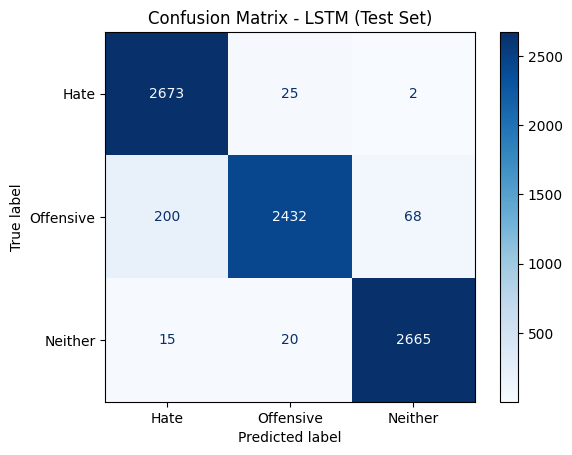

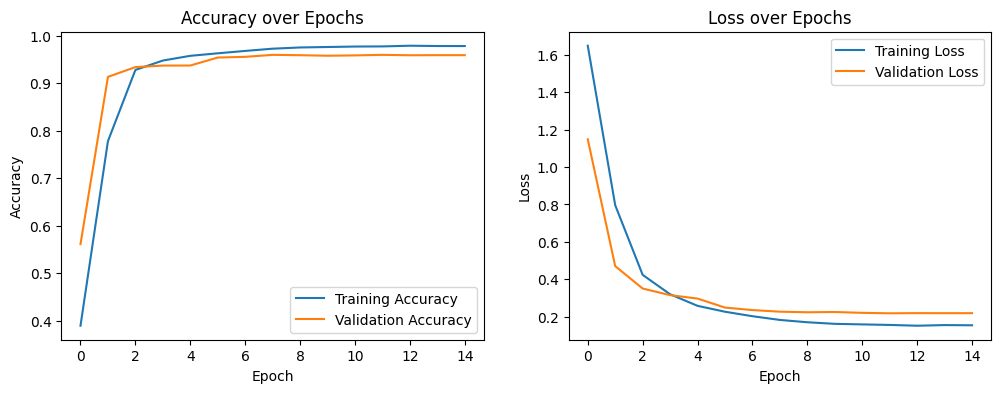

In [15]:
# Evaluate on validation set
val_pred = model.predict(X_val)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = np.argmax(y_val, axis=1)
print("\nClassification Report (Validation - LSTM):\n")
print(classification_report(true_classes, val_pred_classes, target_names=['Hate', 'Offensive', 'Neither']))

# Evaluate on test set
test_pred = model.predict(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = np.argmax(y_test, axis=1)
print("\nClassification Report (Test - LSTM):\n")
print(classification_report(test_true_classes, test_pred_classes, target_names=['Hate', 'Offensive', 'Neither']))

# Confusion matrix for test set
cm = confusion_matrix(test_true_classes, test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate', 'Offensive', 'Neither'])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LSTM (Test Set)')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Test inference-like inputs
inference_tests = [
    ("omg beautiful", 2),
    ("amazing", 2),
    ("holy", 2),
    ("omg", 2),
    ("bastard", 1),
    ("hello guys im here", 2),
    ("great bro", 2),
    ("nigger", 0),
    ("youre a pathetic loser", 1),
    ("lets go", 2),
    ("are you serious", 2),
    ("wtf", 2),
    ("lets fuckin go", 2),
    ("omg how this grok so idiot", 1),
    ("not bad", 2),
    ("well done", 2),
    ("had a long day need a nap", 2),
    ("this is fuckin awesome", 2),
    ("yo this game is dope emoji_positive", 2),
    ("what a bitch always complaining", 1),
    ("this app is a ripoff pure garbage", 1),
    ("muslims are terrorists ban them all", 0),
    ("black people are just lazy leeches", 0),
    ("beautiful weather for a walk today", 2),
    ("i love you", 2),
    ("i mean thats alright", 2),
    ("just stop doing that", 2),
    ("why are you doing that", 2),
    ("why you are so dumb", 1),
    ("dawg do you even had a brain", 1),
    ("indian nigga", 0),
    ("indian jerk bastard", 1),
    ("stfu indian", 0)
]
print("\nInference-like Test Results:")
test_texts = [clean_text(text) for text, _ in inference_tests]
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = np.clip(pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post'), 0, vocab_size - 1)
test_preds = model.predict(test_padded)
test_pred_classes = np.argmax(test_preds, axis=1)
for (text, true_label), pred_class, probs in zip(inference_tests, test_pred_classes, test_preds):
    class_names = ['Hate', 'Offensive', 'Neither']
    print(f"Input: {text}")
    print(f"True Class: {class_names[true_label]}")
    print(f"Predicted Class: {class_names[pred_class]}, Confidence: {probs[pred_class]:.4f}")
    print(f"Scores: Hate={probs[0]:.4f}, Offensive={probs[1]:.4f}, Neither={probs[2]:.4f}\n")


Inference-like Test Results:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Input: omg beautiful
True Class: Neither
Predicted Class: Neither, Confidence: 0.9471
Scores: Hate=0.0041, Offensive=0.0488, Neither=0.9471

Input: amazing
True Class: Neither
Predicted Class: Neither, Confidence: 0.9458
Scores: Hate=0.0036, Offensive=0.0506, Neither=0.9458

Input: holy
True Class: Neither
Predicted Class: Neither, Confidence: 0.9520
Scores: Hate=0.0033, Offensive=0.0446, Neither=0.9520

Input: omg
True Class: Neither
Predicted Class: Offensive, Confidence: 0.5036
Scores: Hate=0.2246, Offensive=0.5036, Neither=0.2718

Input: bastard
True Class: Offensive
Predicted Class: Hate, Confidence: 0.5646
Scores: Hate=0.5646, Offensive=0.3941, Neither=0.0414

Input: hello guys im here
True Class: Neither
Predicted Class: Neither, Confidence: 0.9537
Scores: Hate=0.0029, Offensive=0.0434, Neither=0.9537

Input: great bro
True Class: Neither
Predicted Class: Neither, Confidence: 0.9000
Scores: Hate=0.0044, Offensiv

In [17]:
# Pastikan folder model/lstm ada, jika belum maka buat
os.makedirs('model/lstm/', exist_ok=True)

# Inisialisasi converter dari model Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Konfigurasi agar TensorList ops tidak menyebabkan error
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Konversi ke TensorFlow Lite
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('model/lstm/lstm_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan model dengan format .keras
model.save('model/lstm/lstm_model.keras')  

# Simpan tokenizer ke file pickle
with open('model/lstm/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


INFO:tensorflow:Assets written to: C:\Users\ADVAN\AppData\Local\Temp\tmpd_i0xn0e\assets


INFO:tensorflow:Assets written to: C:\Users\ADVAN\AppData\Local\Temp\tmpd_i0xn0e\assets


Saved artifact at 'C:\Users\ADVAN\AppData\Local\Temp\tmpd_i0xn0e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2030396939856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396940432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396944080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396946192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396939280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396945808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396947344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396947152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396940048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030396947728: